In [172]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = (6,4)
rcParams["figure.dpi"] = 150

from classy import Class
from functools import lru_cache
from scipy.optimize import minimize


import emcee
import getdist
from getdist import plots, MCSamples

# Calculate $\Lambda$CMB power spectrum $P_k$

In [168]:
# initialize class
cosmo = Class()

# Planck 2018 parameters from https://arxiv.org/pdf/1807.06209.pdf
parameters = {'omega_b': 0.02233,
              'omega_cdm': 0.1198,
              'h': 0.6737,
              'A_s':2.097E-9,
              'n_s':0.9652,
              'tau_reio':0.0540}

# set the class parameters 
cosmo.set({'output':'mPk',
           "P_k_max_1/Mpc":10.0,
           **parameters})

# run class
cosmo.compute()


# Data

In [175]:
class Data:
    
    def __init__(self, 
                 data_dir="data",
                 fname="lyman-alpha.txt"):
        
        self.fname = os.path.join(data_dir,fname)
        k, P_k, error = np.loadtxt(self.fname, unpack=True)
        
        
        self.k = k
        self.P_k = P_k
        self.error = error
        
    
    def plot(self, logscale=True):
        plt.errorbar(self.k, self.P_k, self.error, color="k",marker="o", ms=5, ls="")
        
        plt.xlabel("k [h/Mpc]")
        plt.ylabel("$P_k [Mpc/h^3]$")
        
        if logscale:
            plt.xscale("log")
            plt.yscale("log")

In [176]:
data = Data(fname="lyman-alpha.txt")

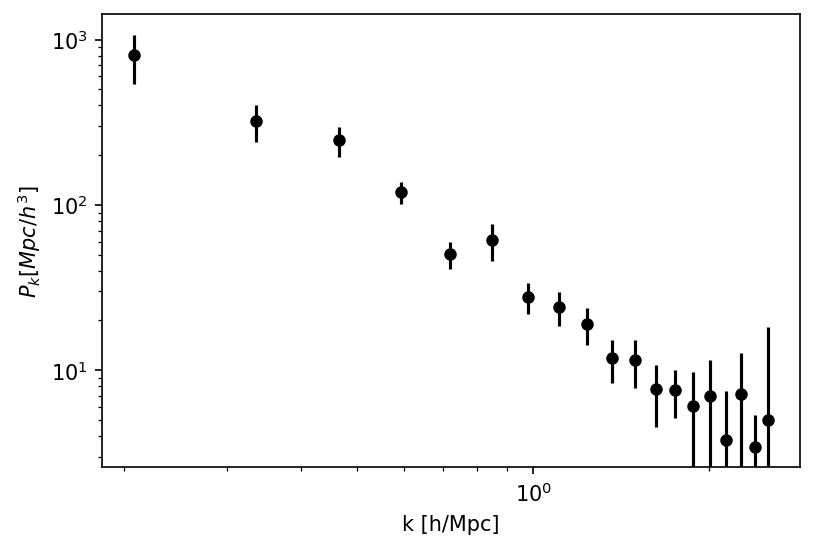

In [177]:
data.plot()

# Alpha Beta Gamma model

In [186]:
class Model:
    
    def __init__(self,
                 cosmology,
                 k,
                 alpha=0,
                 beta=2,
                 gamma=-5,
                 ):
        
        # set the hubble parameter
        h = cosmology.h()
        
        # set the model parameters
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        # set the k at which the model power spectrum should be calculated 
        self.k = k 
        
        # calculate the transfer function 
        # Eq. 4 in Murgia+2018
        self.T_k = self.get_T_k(self.k, self.alpha, self.beta, self.gamma)
        
        # calculate the base (lamdaCMB power spectrum)
        # since this is saved as a list because it needs to be calcuated once
        self.P_k_lcdm = [cosmo.pk(k,0)*h**3 for k in self.k]
        
        
        
    
    # calculate the power spectrum 
    # Eq. 1 in Murgia+2018
    @property    
    def P_k(self):
        return self.get_P_k(self.k, self.P_k_lcdm, self.alpha, self.beta, self.gamma)
    
    
    @staticmethod    
    def get_T_k(k, alpha, beta, gamma):
        """# Eq. 4 in Murgia+2018"""
        
        return (1+(alpha*k)**beta)**gamma
    
    
    @staticmethod
    def get_P_k(k, P_k_lcdm, alpha, beta, gamma):
        """# Eq. 1 in Murgia+2018"""
        assert hasattr(k, "__len__"), "k has to be a list or array"
        assert len(k)==len(P_k_lcdm)
        
        T_k = Model.get_T_k(k, alpha, beta, gamma)
        
        return [T_k[i]**2*P_k_lcdm[i] for i,_ in enumerate(k)]
    
    def plot(self,logscale=True):
        
        plt.plot(self.k, self.P_k, "tab:red", lw=1)

        plt.xlabel("k [h/Mpc]")
        plt.ylabel("$P_k$")
        
        if logscale:
            plt.xscale("log")
            plt.yscale("log")

In [187]:
model = Model(cosmo, data.k, alpha=0.)

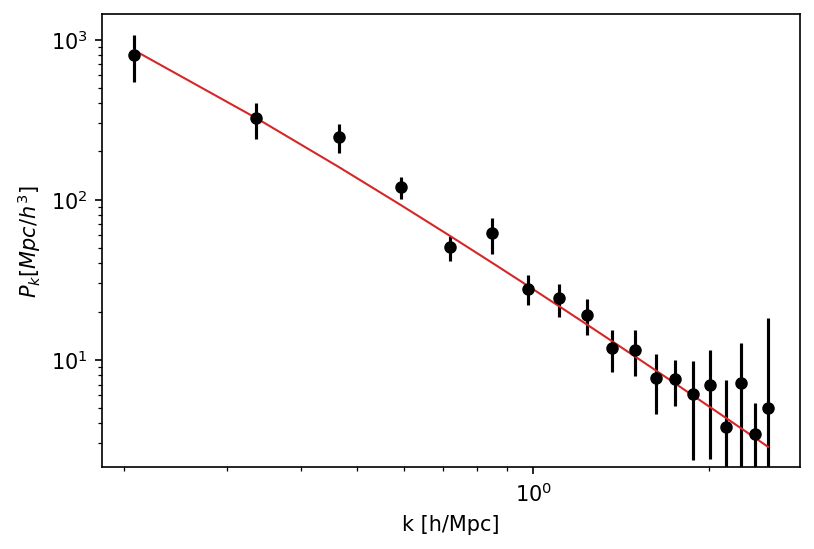

In [188]:
model.plot()
data.plot()

# Posterior sampling

## alpha beta gamma

In [252]:
class Posterior:
    """posterior for the Murgia+2018 model"""
    
    def __init__(self,
                 data,
                 model,
                 guess=[0,0,0],
                 n_walkers = 50,
                 n_steps = 100000):
        

        self.model = model
        self.data = data
        self.data_params = data.k, data.P_k, data.error

        self.guess = guess
        
        self.n_walkers = n_walkers 
        self.n_dim = 3
        self.n_steps = n_steps
        
        
    @staticmethod
    def log_likelihood(model_params,  P_k_lcdm, data_params,):
        """log of gaussian likelihood """
        alpha, beta, gamma = model_params
        k, P_k, error = data_params
        
        P_k_model = Model.get_P_k(k, P_k_lcdm, alpha, beta, gamma )
        
        sigma2_model = error ** 2 #+ y_model ** 2 * np.exp(2 * log_f)
        return -0.5 * np.sum((P_k - P_k_model) ** 2 / sigma2_model )
    
    @staticmethod
    def neg_log_likelihood(model_params, P_k_lcdm, data_params):
        return -Posterior.log_likelihood(model_params, P_k_lcdm, data_params)
    
    @staticmethod
    def log_prior(model_params):
        """log of flat prior"""
        alpha, beta, gamma = model_params
        if 0. < alpha < 1 and 0 < beta < 10.0 and -10.0 < gamma < 1:
            return 0.0
        return -np.inf
    
    @staticmethod
    def log_probability(model_params,P_k_lcdm, data_params):
        k, P_k, error = data_params
        lp = Posterior.log_prior(model_params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + Posterior.log_likelihood(model_params, P_k_lcdm, data_params)
    
    def sample(self, P_k_lcdm):
        """sample the posterior"""
        
        # find the maximum likelihood (min of -log_lkl)
        lok_lik_min = minimize(self.neg_log_likelihood, self.guess, args=(P_k_lcdm,self.data_params) )
        
        # distribute the walkers around the maximum likelihood
        # taken from the emcee tutorial
        pos_0 = lok_lik_min.x + 1e-3 * np.random.randn(self.n_walkers, self.n_dim)

        # start sampling the posterior 
        sampler = emcee.EnsembleSampler(self.n_walkers, self.n_dim, self.log_probability, args=(P_k_lcdm, self.data_params))
        sampler.run_mcmc(pos_0,self.n_steps , progress=True)
        self.samples = sampler.get_chain()
        
    def plot(self):
        
        fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
        
        labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
        for i in range(self.n_dim):
            ax = axes[i]
            ax.plot(self.samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(self.samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");

In [253]:
posterior = Posterior(data, model, )

In [254]:
posterior.sample(model.P_k_lcdm)

/Users/siavashyasini/anaconda3/envs/cosmolab/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in power
/Users/siavashyasini/anaconda3/envs/cosmolab/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/siavashyasini/anaconda3/envs/cosmolab/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in power
  0%|          | 0/100000 [00:00<?, ?it/s]/Users/siavashyasini/anaconda3/envs/cosmolab/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100000/100000 [04:34<00:00, 363.78it/s]


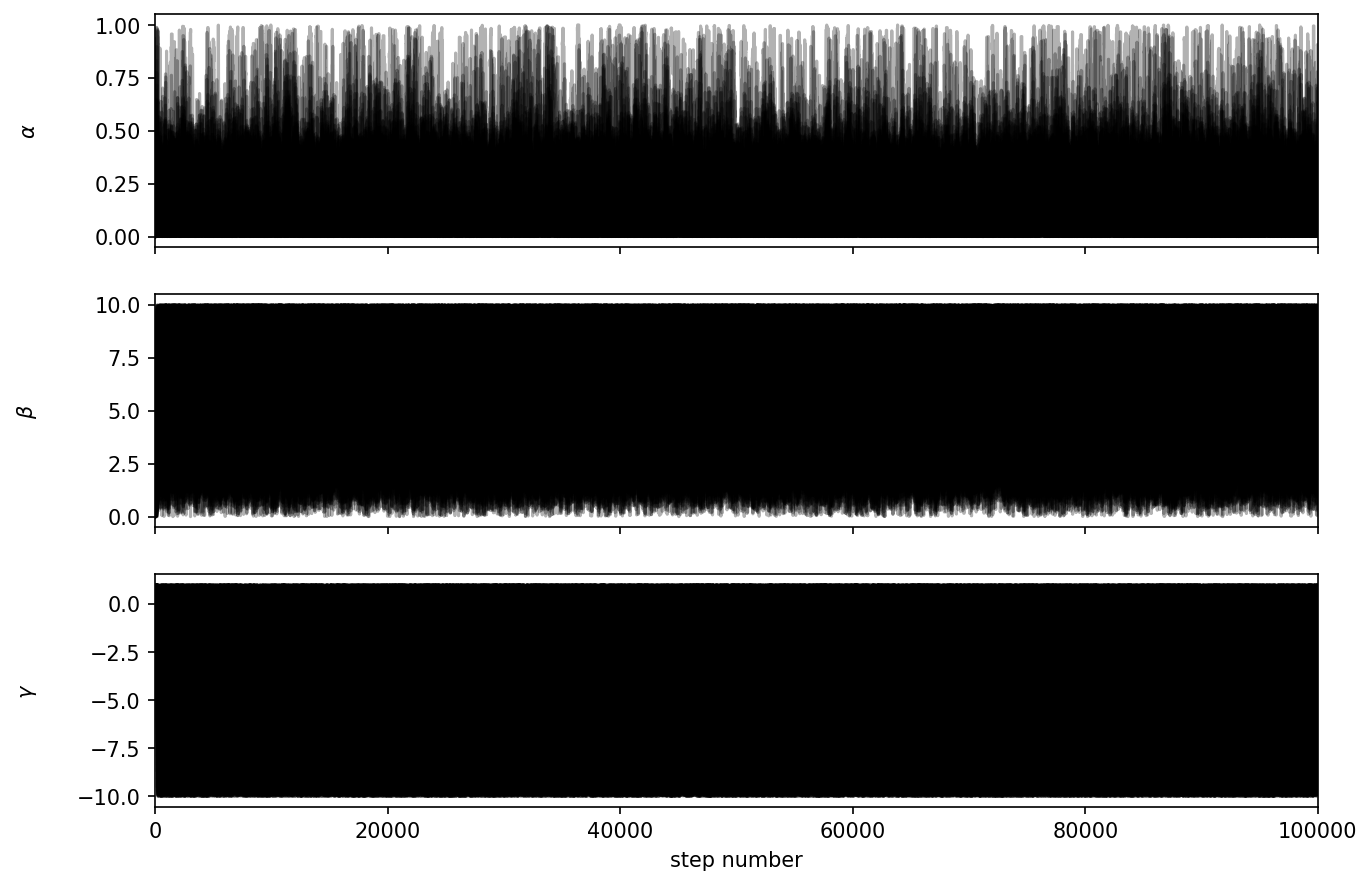

In [257]:
posterior.plot()

Removed no burn in


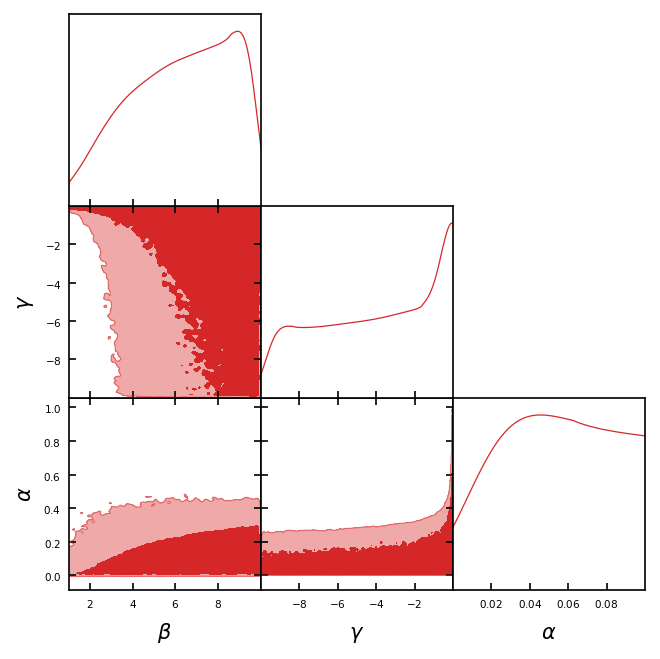

In [266]:
# roll the last axis backwards by 1 to match the parameter order with Murgia+18
samples = MCSamples(samples=np.roll(posterior.samples[:,:,:],-1,axis=-1), names=[r"$\beta$", r"$\gamma$",r"$\alpha$"])

g = plots.getSubplotPlotter(subplot_size=1.5)

g.settings.lw_contour = 1.
g.settings.legend_fontsize = 14
g.settings.lab_fontsize = 14
g.settings.axes_fontsize = 9

g.triangle_plot(samples, 
                filled = True,
                contour_colors=["tab:red"],
                param_limits={r"$\beta$":[1,10],
                              r"$\gamma$":[-10,0],
                              r"$\alpha$":[0,.1]} )

plt.savefig("alpha_beta_gamma_posterior.png", dpi=200, bbox_inches="tight")
